In [1]:
from gwpy.table import GravitySpyTable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions

H1_O1 = GravitySpyTable.read('data/H1_O1.csv')
H1_O2 = GravitySpyTable.read('data/H1_O2.csv')
L1_O1 = GravitySpyTable.read('data/L1_O1.csv')
L1_O2 = GravitySpyTable.read('data/L1_O2.csv')

In [2]:
glitches = ["1080Lines", "Helix", "Light_Modulation",
            "Paired_Doves", "Repeating_Blips", "Scattered_Light", "Scratchy", "Violin_Mode", "Whistle", "Wandering_Line",
            "1400Ripples", "Blip", "Chirp", "Koi_Fish", "Tomte", "Air_Compressor", "Power_Line", "Low_Frequency_Burst", "Low_Frequency_Lines"]

In [3]:
lst = []

for glitch in glitches:
    data1 = H1_O1[(H1_O1["ml_label"] == glitch) & (H1_O1["ml_confidence"] > 0.9)]
    data2 = H1_O2[(H1_O2["ml_label"] == glitch) & (H1_O2["ml_confidence"] > 0.9)]
    data3 = L1_O1[(L1_O1["ml_label"] == glitch) & (L1_O1["ml_confidence"] > 0.9)]
    data4 = L1_O2[(L1_O2["ml_label"] == glitch) & (L1_O2["ml_confidence"] > 0.9)]

    data = np.concatenate([np.array(data1['snr'][data1['snr'] < 400]) - 7.5,
                         np.array(data2['snr'][data2['snr'] < 400]) - 7.5, 
                         np.array(data3['snr'][data3['snr'] < 400]) - 7.5, 
                         np.array(data4['snr'][data4['snr'] < 400]) - 7.5])
    lst.append(data)


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  8.35it/s]


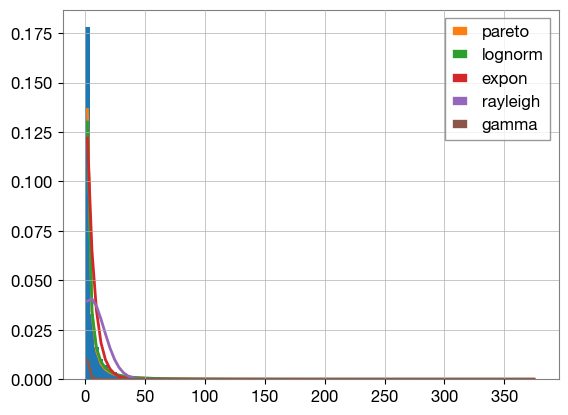

In [4]:
glitch_best = []

for i in range(len(glitches)):
    f = Fitter(lst[i], 
    distributions=['expon', 'gamma', 'lognorm', 'rayleigh', 'pareto'])
    f.fit()
    f.get_best(method = 'sumsquare_error')
    f.summary()
    glitch_best.append(f.get_best(method = 'sumsquare_error'))


In [5]:
# import scipy

# f.df_errors['sumsquare_error'].sort_values().head(10)
# size = 16384
# range = [0, 100]

# distribution = list(f.get_best().keys())[0]
# stats = list(f.get_best().values())[0]

# q = scipy.stats.burr12(c=stats['c'], d=stats['d'], loc=stats['loc'], scale=stats['scale'])
# rv = pd.Series(q.rvs(size=size))
# x = np.linspace(0, 100, size)
# y = q.pdf(x)

# plt.hist(lst[0], bins=100, range=range, density=True)
# plt.plot(x, y, lw=2)



In [25]:
from pylab import linspace, plot
import scipy

distr_list = []
size = 16384
line_data = []
i = 0
for g in glitch_best:
    distribution = list(g.keys())[0]
    stats = list(g.values())[0]
    
    if distribution == 'gamma':
        q = scipy.stats.gamma(a=stats['a'], loc=stats['loc'], scale=stats['scale'])
    elif distribution == 'expon':
        q = scipy.stats.expon(loc=stats['loc'], scale=stats['scale'])
    elif distribution == 'lognorm':
        q = scipy.stats.lognorm(s=stats['s'], loc=stats['loc'], scale=stats['scale'])
    elif distribution == 'rayleigh':
        q = scipy.stats.rayleigh(loc=stats['loc'], scale=stats['scale'])
    elif distribution == 'pareto':
        q = scipy.stats.pareto(b=stats['b'], loc=stats['loc'], scale=stats['scale'])


    
        # Build PDF and turn into pandas Series
    x = np.linspace(0, 400, size)
    y = q.pdf(x)
    line_data.append((x, y))
    distr_list.append([glitches[i], distribution, stats])
    i += 1



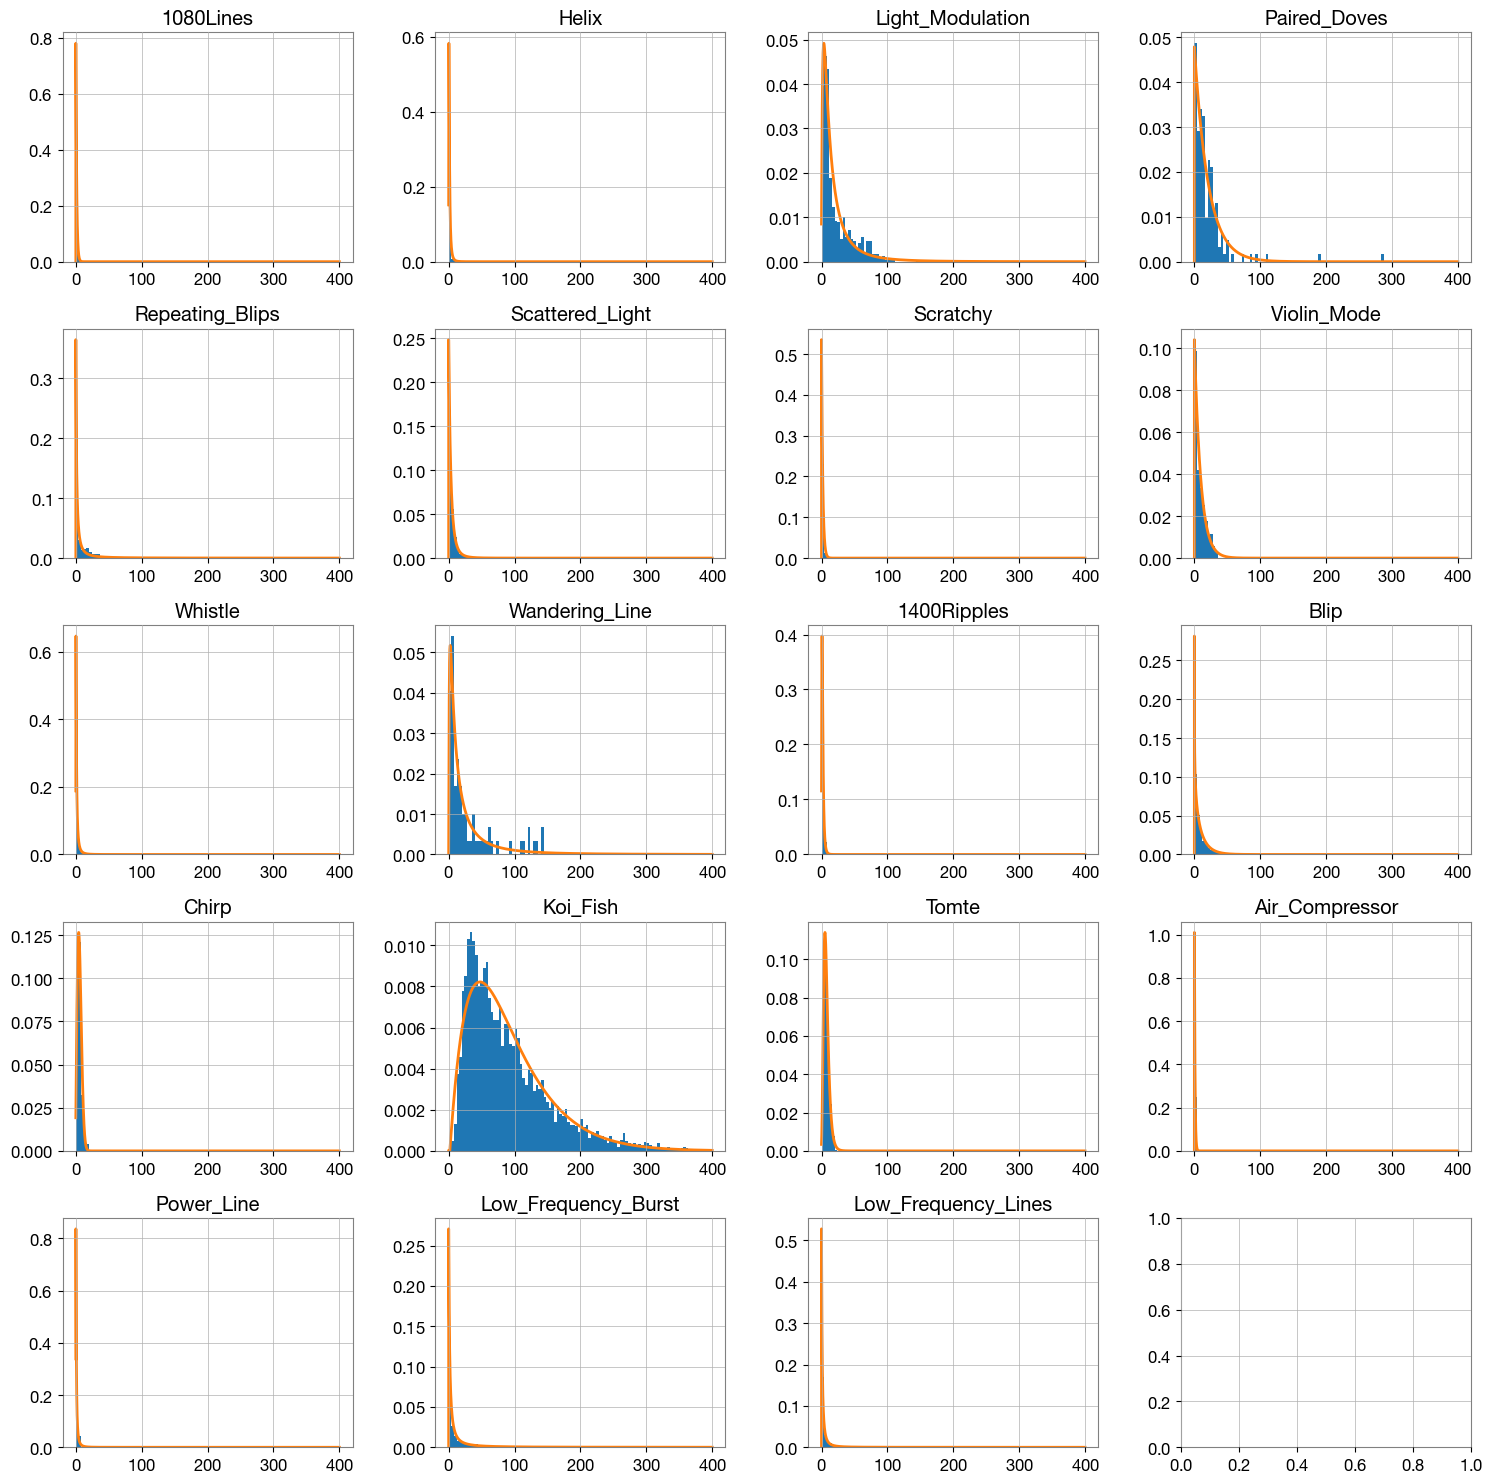

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
size = 16384
range = [0, 400]

for i, axi in enumerate(ax.flat):
    if i == 19:
        break

    axi.hist(lst[i], bins=100, range=range, density=True)
    axi.plot(line_data[i][0], line_data[i][1], lw=2)

    axi.set_title(glitches[i])

plt.tight_layout()

In [35]:
df = pd.DataFrame(distr_list)
df.to_csv('SNR_weights.csv', index=False)